# Handwritten Digit Recognition (MNIST)
## Using 5 layer Convolutional Neural Network 
### Activation function: RELU  
### Learning rate: dynamic 
### Including Dropouts for each RELU layer
### Batch Normalization

In [1]:
# including helper file to use some handy functions
import os
helper_file = os.getcwd() + '\\helpers.ipynb'
%run $helper_file

# importing needed libraries
import numpy as np
import tensorflow as tf
import math
import pandas as pd

In [2]:
# reading train and test file
train_data = pd.read_csv(os.getcwd() + '\\KaggleInput\\train.csv')
pred_data   = pd.read_csv(os.getcwd() + '\\KaggleInput\\test.csv')

In [10]:
# parameters
LEARNING_RATE = 0.003
BATCH_SIZE = 100
ITERATION_COUNT = 50
ACCURACY_CHECK = 10
TOTAL_COUNT = 42000 # training image count in input csv file
TRAIN_COUNT = 40000
TEST_COUNT = 2000

In [22]:
# extracting pixel values and label for each image
# splitting images to train and test data to validate our prediction
X_train_flat  = train_data.iloc[:TRAIN_COUNT, 1:].values
X_test_flat   = train_data.iloc[TRAIN_COUNT:, 1:].values
Y_values = train_data["label"].values
X_pred_flat   = pred_data.values
X_all_flatt = train_data.iloc[:TOTAL_COUNT, 1:].values

# input pixel values range is [0:255]
# we need to change the range to [0:1]
# the easiest way is to devide by maximum 255
X_train_flat = X_train_flat / 255
X_test_flat  = X_test_flat / 255
X_pred_flat  = X_pred_flat / 255
X_all_flat   = X_all_flatt / 255

# creating list for each label
# each row's values will be zero 
# except the index of the label
# mapping should be as below: 
# 0 ~ [1 0 0 0 0 0 0 0 0 0]
# 1 ~ [0 1 0 1 0 0 0 0 0 0]
# 2 ~ [0 0 1 0 0 0 0 0 0 0]
# 3 ~ [0 0 0 1 0 0 0 0 0 0]
# 4 ~ [0 0 0 0 1 0 0 0 0 0]
# 5 ~ [0 0 0 0 0 1 0 0 0 0]
# 6 ~ [0 0 0 0 0 0 1 0 0 0]
# 7 ~ [0 0 0 0 0 0 0 1 0 0]
# 8 ~ [0 0 0 0 0 0 0 0 1 0]
# 9 ~ [0 0 0 0 0 0 0 0 0 1]
Y_labels = np.zeros(shape=(TOTAL_COUNT,10))

for i in range(TOTAL_COUNT):
    Y_labels[i][Y_values[i]] = 1

# splitting labels to train and test data to validate our prediction
Y_train = Y_labels[:TRAIN_COUNT]
Y_test  = Y_labels[TRAIN_COUNT:TOTAL_COUNT]
Y_all = Y_labels

In [5]:
# the batch size equals to BATCH_SIZE it will
# starts from 0 to until the last index of
# batch equals to TOTAL_COUNT
BATCH_COUNTER = 0

def next_batch(all_images, all_labels):
    
    # accessing BATCH_COUNTER inside function
    global BATCH_COUNTER
    
    # check if exceeds to the last index then reset batch_counter
    if BATCH_COUNTER == len(all_labels) / BATCH_SIZE:
        BATCH_COUNTER = 0

    # setting first and last index of data
    index_from = BATCH_COUNTER * BATCH_SIZE
    index_to   = (BATCH_COUNTER + 1) * BATCH_SIZE
    
    # loading a batch of training images and labels
    image_batch = all_images[index_from:index_to]
    label_batch = all_labels[index_from:index_to]
    
    # incrementing batch_counter for the next iteration
    BATCH_COUNTER += 1 
    
    return image_batch, label_batch;

In [25]:
def train(train_X_flat, train_Y, test_X_flat, test_Y, pred_X_flat, iteration_count, accuracy_check = 0):
    #def train(mnist_data, batch_size, iteration_count, accuracy_check):
    
    IMAGE_WIDTH  = 28 # input image width
    IMAGE_HEIGHT = 28 # input image height
    C0 = 1            # input channel count
    C1 = 24 # convolutional network channel 1 count 
    C2 = 48 # convolutional network channel 2 count
    C3 = 64  # convolutional network channel 3 count
    C4 = 200  # fulley connected layer size
    C5 = 10  # output count (digit count 0 to 9)
    
    # input image placeholder: 28x28 grayscale
    # the first dimension is each image's index
    X = tf.placeholder(tf.float32, shape=[None, IMAGE_WIDTH, IMAGE_HEIGHT, C0])
    
    # placeholder for correct answers
    Y_ = tf.placeholder(tf.float32, [None, C5])
    
    # paceholder for learing_rate variable
    lr = tf.placeholder(tf.float32)
    
    # test flag for batch norm
    tst = tf.placeholder(tf.bool)
    iter = tf.placeholder(tf.int32)
    
    # dropout probability
    pkeep = tf.placeholder(tf.float32)
    pkeep_conv = tf.placeholder(tf.float32)
    
    def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
        exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
        bnepsilon = 1e-5
        if convolutional:
            mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
        else:
            mean, variance = tf.nn.moments(Ylogits, [0])
        update_moving_everages = exp_moving_avg.apply([mean, variance])
        m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
        v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
        Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
        return Ybn, update_moving_everages

    def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
        return Ylogits, tf.no_op()
    
    def compatible_convolutional_noise_shape(Y):
        noiseshape = tf.shape(Y)
        noiseshape = noiseshape * tf.constant([1,0,0,1]) + tf.constant([0,1,1,0])
        return noiseshape
        
    # weights
    W1 = tf.Variable(tf.truncated_normal([6, 6, C0, C1], stddev = 0.1)) 
    W2 = tf.Variable(tf.truncated_normal([5, 5, C1, C2], stddev = 0.1))
    W3 = tf.Variable(tf.truncated_normal([4, 4, C2, C3], stddev = 0.1))
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * C3, C4], stddev = 0.1))
    W5 = tf.Variable(tf.truncated_normal([C4, C5], stddev = 0.1))
    
    # biases
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [C1]))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [C2]))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [C3]))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [C4]))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [C5]))

    # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
    pkeep = tf.placeholder(tf.float32)
    
    # model
    stride = 1  # output is 28x28
    Y1l = tf.nn.conv2d(X, W1, strides = [1, stride, stride, 1], padding = 'SAME')
    Y1bn, update_ema1 = batchnorm(Y1l, tst, iter, B1, convolutional = True)
    Y1r = tf.nn.relu(Y1bn)
    Y1 = tf.nn.dropout(Y1r, pkeep_conv, compatible_convolutional_noise_shape(Y1r))

    stride = 2  # output is 14x14
    Y2l = tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME')
    Y2bn, update_ema2 = batchnorm(Y2l, tst, iter, B2, convolutional=True)
    Y2r = tf.nn.relu(Y2bn)
    Y2 = tf.nn.dropout(Y2r, pkeep_conv, compatible_convolutional_noise_shape(Y2r))

    stride = 2  # output is 7x7
    Y3l = tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME')
    Y3bn, update_ema3 = batchnorm(Y3l, tst, iter, B3, convolutional=True)
    Y3r = tf.nn.relu(Y3bn)
    Y3 = tf.nn.dropout(Y3r, pkeep_conv, compatible_convolutional_noise_shape(Y3r))

    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * C3])
    
    Y4l = tf.matmul(YY, W4)
    Y4bn, update_ema4 = batchnorm(Y4l, tst, iter, B4)
    Y4r = tf.nn.relu(Y4bn)
    Y4 = tf.nn.dropout(Y4r, pkeep)
    Ylogits = tf.matmul(Y4, W5) + B5
    Y = tf.nn.softmax(Ylogits)
    
    update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)

    # cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
    # TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
    # problems with log(0) which is NaN
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y_)
    cross_entropy = tf.reduce_mean(cross_entropy) * 100
    
    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

    # initialisation
    init = tf.global_variables_initializer()

    # start computation
    sess = tf.Session()
    sess.run(init)
    
    # preparing return values
    counter = 0 
    learning_rates = np.zeros(1)
    
    if accuracy_check != 0:
        upper_bound = int(iteration_count / accuracy_check)
        iterations = np.arange(0, upper_bound)
        train_accuracy = np.zeros(upper_bound)
        train_loss = np.zeros(upper_bound)
        test_accuracy = np.zeros(upper_bound)
        test_loss = np.zeros(upper_bound)
        test_X = np.reshape(test_X_flat, (-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
    
    for i in range(iteration_count):
        
        # learning rate decay
        max_learning_rate = 0.002
        min_learning_rate = 0.0001
        decay_speed = 1600
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
        
        # load batch of images and correct answers
        batch_X_flat, batch_Y = next_batch(train_X_flat, train_Y)
        batch_X = np.reshape(batch_X_flat, (-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
        
        # train
        # the backpropagation training step
        sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate, tst: False, pkeep: 0.75, pkeep_conv: 1.0})
        sess.run(update_ema, {X: batch_X, Y_: batch_Y, tst: False, iter: i, pkeep: 1.0, pkeep_conv: 1.0})
        
        if (accuracy_check != 0) and (i % accuracy_check == 0):

            a, c = sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y, tst: False, pkeep: 1.0, pkeep_conv: 1.0})
            train_accuracy[counter] = a
            train_loss[counter] = c
            print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        
        
            pred, a, c = sess.run([Y, accuracy, cross_entropy], {X: test_X, Y_: test_Y, tst: True, pkeep: 1.0, pkeep_conv: 1.0})
            test_accuracy[counter] = a
            test_loss[counter] = c
            predictions = tf.argmax(pred,1).eval(session=sess)
            print(str(i) + "test accuracy:" + str(a) + " test loss: " + str(c))
            
            counter += 1
            
    learning_rates[0] = learning_rate
    #acc = accuracy.eval(session = sess, feed_dict = {X: mnist_data.test.images, Y_: mnist_data.test.labels, pkeep: 1.0})
    #print('Learning Rate: {}, Accuracy: {}'.format(learning_rate, acc))
    
    if not(pred_X_flat is None):
        pred_X = np.reshape(pred_X_flat, (-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
        pred = sess.run([Y], feed_dict = {X: pred_X})
        predictions = pred[0]
    
    sess.close()
    
    if not(pred_X_flat is None):
        return iterations, predictions
    else:
        return iterations, train_accuracy, train_loss, test_accuracy, test_loss, predictions, learning_rates
    

In [26]:
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []

%time acc_check, temp_train_acc, temp_train_loss, temp_test_acc, temp_test_loss, predictions, learning_rates = train(X_train_flat, Y_train, X_test_flat, Y_test, None, ITERATION_COUNT, ACCURACY_CHECK)

train_accuracy.append(temp_train_acc)
train_loss.append(temp_train_loss)
test_accuracy.append(temp_test_acc)
test_loss.append(temp_test_loss)

0: accuracy:0.86 loss: 87.8753 (lr:0.002)
0test accuracy:0.4165 test loss: 172.218
10: accuracy:0.9 loss: 40.2782 (lr:0.00198816203218445)
10test accuracy:0.863 test loss: 46.3454
20: accuracy:0.93 loss: 30.5284 (lr:0.0019763978209383745)
20test accuracy:0.9085 test loss: 31.4066
30: accuracy:0.92 loss: 25.6069 (lr:0.0019647069067207767)
30test accuracy:0.9215 test loss: 26.9531
40: accuracy:0.96 loss: 17.8353 (lr:0.001953088832853832)
40test accuracy:0.932 test loss: 22.9703
Wall time: 11.1 s


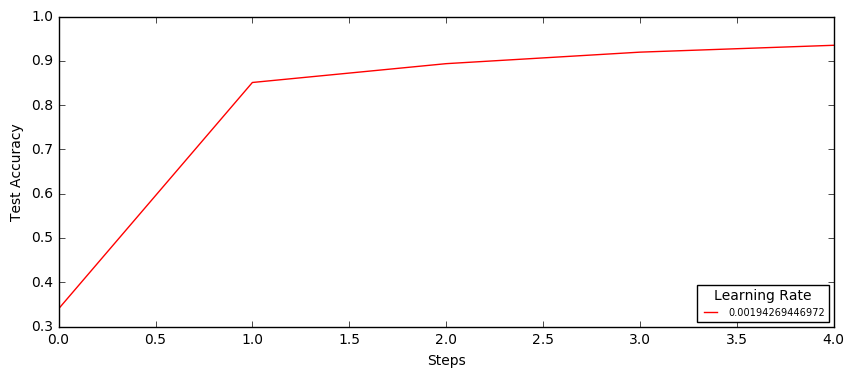

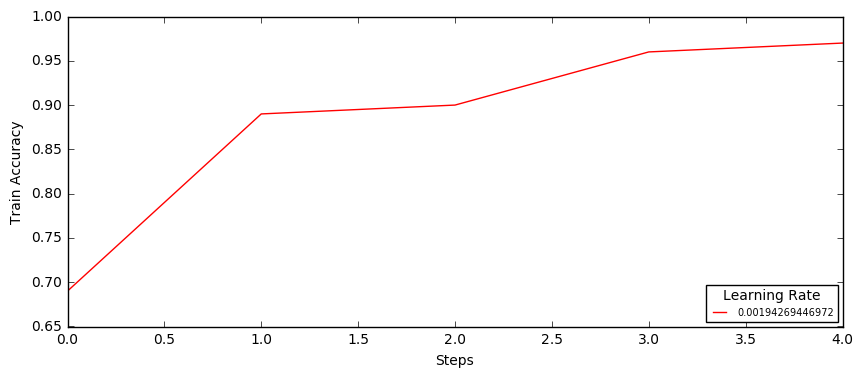

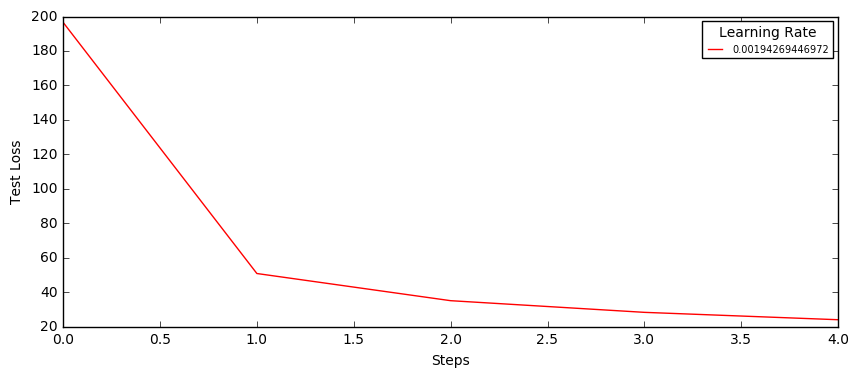

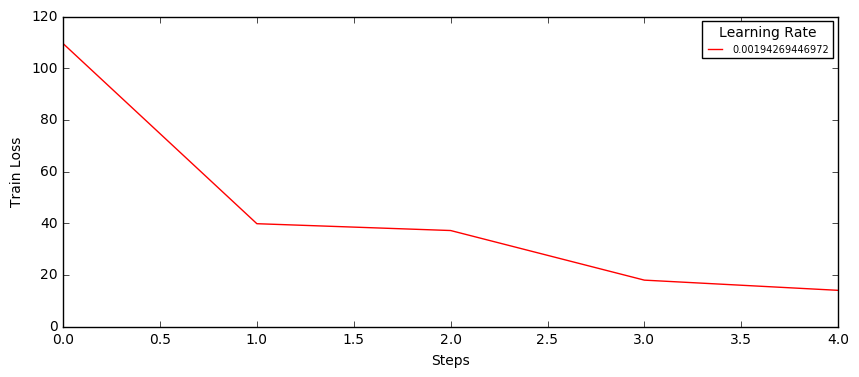

In [17]:
plot_performance(acc_check, learning_rates, train_accuracy, train_loss, test_accuracy, test_loss)

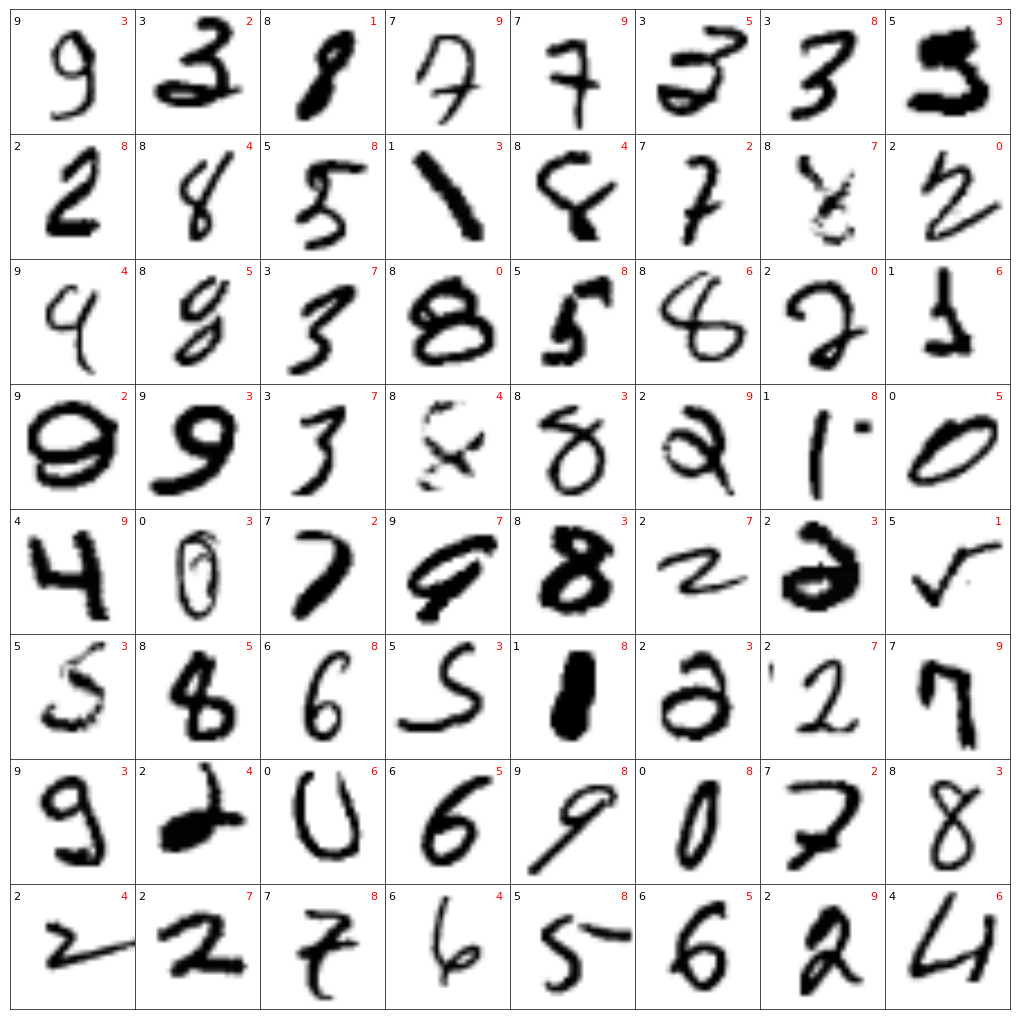

In [19]:
labels = np.argmax(Y_test, 1)
incorects = np.not_equal(labels, predictions)
plot_batch_images(X_test_flat[incorects], labels[incorects], predictions[incorects], 64)

In [27]:
%time acc_check, predictions = train(X_all_flat, Y_all, None, None, X_pred_flat, ITERATION_COUNT, 0)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_67' with dtype bool
	 [[Node: Placeholder_67 = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: moments_33/sufficient_statistics/Shape/_75 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_328_moments_33/sufficient_statistics/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_67', defined at:
  File "C:\Users\amirp\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\amirp\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\amirp\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Users\amirp\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\amirp\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\amirp\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\amirp\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\amirp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-0d7874a4f0dd>", line 1, in <module>
    get_ipython().magic('time acc_check, predictions = train(X_all_flat, Y_all, None, None, X_pred_flat, ITERATION_COUNT, 0)')
  File "C:\Users\amirp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2158, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2079, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-60>", line 2, in time
  File "C:\Users\amirp\Anaconda3\lib\site-packages\IPython\core\magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1180, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "<ipython-input-25-9d336adbd942>", line 24, in train
    tst = tf.placeholder(tf.bool)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1512, in placeholder
    name=name)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\amirp\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_67' with dtype bool
	 [[Node: Placeholder_67 = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: moments_33/sufficient_statistics/Shape/_75 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_328_moments_33/sufficient_statistics/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
batch_X , batch_Y = next_batch(X_pred_flat, predictions)
plot_batch_images(batch_X, np.argmax(batch_Y, 1))